In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling'

In [3]:
infections_cleaned = pd.read_csv(f"{epi_dir}/preprocessed/infections.csv", index_col=0)
infections_cleaned.columns = np.arange(367)

df_screen = pd.read_csv(f"{epi_dir}/preprocessed/screening.csv", index_col=0)
df_screen.columns = np.arange(367)

df_floor = pd.read_csv(f"{epi_dir}/preprocessed/floor_trace.csv", index_col=0)
df_floor.columns = np.arange(367)

df_room = pd.read_csv(f"{epi_dir}/preprocessed/room_trace.csv", index_col=0)
df_room.columns = np.arange(367)

In [4]:
window_starts = [i*7 for i in range(367//7 + 1)]

window_stops = [w -1 for w in window_starts[1:]] + [367]

windows = list(zip(window_starts, window_stops))

In [5]:
infections_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
for n in infections_cleaned.index:
    for t, w in enumerate(windows):
        a, b = w
        week_data = infections_cleaned.loc[n, a:b]
        if np.isnan(week_data).all():
            infections_rs.loc[n, t] = np.nan
        else:
            infections_rs.loc[n, t] = np.nanmax(week_data)

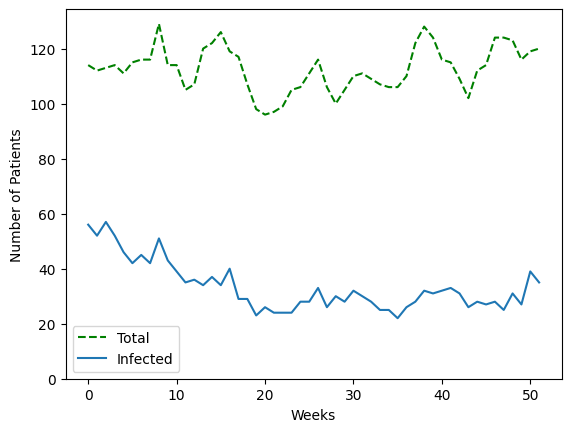

In [6]:
NN = infections_rs.notna().sum(0)[:-1]
II = (infections_rs == 1).sum(0)[:-1]
sns.lineplot(NN, color="green", linestyle="--", label="Total")
sns.lineplot(II, label="Infected")
plt.ylim(bottom=0)
plt.ylabel("Number of Patients")
plt.xlabel("Weeks")
# plt.savefig("images/crkp.png")
plt.show()

In [7]:
df_facility_rs = infections_rs.notna().astype(int)

In [8]:
NN.mean()

112.63461538461539

#### screening data

In [9]:
df_screen_rs = pd.DataFrame(index=infections_cleaned.index, columns=np.arange(len(windows)))
df_screen_rs[0] = infections_rs[0]
for t in range(1, len(windows)):
    newly_admitted = infections_rs[t].notna() * infections_rs[t-1].isna()
    
    df_screen_rs[t][newly_admitted] = infections_rs[t][newly_admitted]
    assert df_screen_rs[t][newly_admitted].notna().all()

/var/folders/sk/4ngl_8x117n6zr60rtkvrr300000gn/T/ipykernel_79689/1966212232.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_screen_rs[t][newly_admitted] = infections_rs[t][newly_admitted]
/var/folders/sk/4ngl_8x117n6zr60rtkvrr300000gn

In [10]:
A = df_screen_rs.sum(0)
B = df_screen_rs.notna().sum(0)

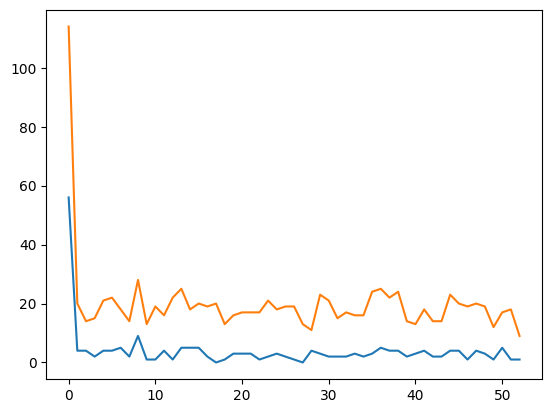

In [11]:
sns.lineplot(A)
sns.lineplot(B)
plt.show()

In [12]:
B[1:].mean()

18.03846153846154

In [13]:
A[1:].mean()

2.8461538461538463

### floor and room trace data

In [14]:
df_floor_rs = pd.DataFrame(index=df_floor.index, columns=np.arange(len(windows)))
for n in df_floor.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_floor.loc[n, a:b])
        df_floor_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]
        # if not np.isnan(week_data).all():
        #     df_screen_rs.loc[n, t] = np.nanmax(week_data)

In [15]:
df_room_rs = pd.DataFrame(index=df_room.index, columns=np.arange(len(windows)))
for n in df_room.index:
    admitted = False
    for t, w in enumerate(windows):
        a, b = w
        week_data = np.array(df_room.loc[n, a:b])
        df_room_rs.loc[n, t] = week_data[np.argmax(week_data > 0)]

## "observed" data

In [25]:
total_count = infections_rs.sum(0).values

In [26]:
floor_counts = []
X = infections_rs.values
F = df_floor_rs.values
# big change: ignore floor 5
for i in [1,2,3,4,6]:
    floor_count = np.nansum(X * (F == i), axis=0)
    floor_counts.append(floor_count)

In [18]:
T = X.shape[1]
# room_infect_density = np.ones(T)
room_count = np.empty(T)
R = df_room_rs.values
for t in range(T):
    r = R[:, t]
    x = X[:, t]
    rx, ry = np.meshgrid(r, r)
    rC = (rx == ry).astype(int)
    I = (x == 1).astype(int)
    infected_roommates = (rC * I).sum(1)
    # rm.append(infected_roommates.sum())
    # if infected_roommates.max() > 0:
    #     room_infect_density[t] = infected_roommates[infected_roommates > 0].mean()
    room_count[t] = (infected_roommates > 1).sum()

In [28]:
observed_data = np.stack(([total_count] + floor_counts + [room_count]))

In [29]:
observed_data = observed_data.astype(float)

In [30]:
observed_data

array([[56., 52., 57., 52., 46., 42., 45., 42., 51., 43., 39., 35., 36.,
        34., 37., 34., 40., 29., 29., 23., 26., 24., 24., 24., 28., 28.,
        33., 26., 30., 28., 32., 30., 28., 25., 25., 22., 26., 28., 32.,
        31., 32., 33., 31., 26., 28., 27., 28., 25., 31., 27., 39., 35.,
        27.],
       [ 4., 11., 14., 17., 14., 17., 16., 14., 18., 14., 10., 12., 12.,
        11., 12., 13., 14.,  9.,  4.,  3.,  3.,  5.,  0.,  0.,  1.,  0.,
         1.,  4.,  7.,  7.,  8., 10.,  8.,  6.,  4.,  5.,  6.,  6.,  8.,
        10.,  7.,  8.,  6.,  5.,  6.,  6.,  5.,  5.,  4.,  4.,  6.,  8.,
         6.],
       [16.,  6.,  7.,  1.,  4.,  1.,  2.,  1.,  4.,  3.,  4.,  1.,  3.,
         1.,  3.,  3.,  3.,  0.,  3.,  2.,  3.,  1.,  4.,  1.,  3.,  3.,
         5.,  0.,  3.,  1.,  1.,  2.,  3.,  0.,  3.,  2.,  2.,  2.,  4.,
         2.,  5.,  4.,  4.,  1.,  2.,  2.,  1.,  2.,  6.,  3.,  6.,  0.,
         2.],
       [19., 27., 25., 24., 19., 18., 20., 20., 20., 20., 18., 13., 13.,
        1

In [36]:
np.median(room_count / 95)

0.08421052631578947

### sanity checks

In [31]:
assert ((df_floor_rs > 0).values == (df_room_rs > 0).values).all()
assert ((infections_rs.notna()).values == (df_facility_rs > 0).values).all()
for n, r in df_screen_rs.iterrows():
    for t, v in r.items():
        if not np.isnan(v):
            assert infections_rs.loc[n, t] == v
            # assert not np.isnan(infections_cleaned.loc[n, t])
assert ((infections_rs.notna()).values == (df_floor_rs > 0).values).all()

#### write out data

In [31]:
# takeaway from sanity check: each week sees about 20 new patients admitted

output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed/resampled'
infections_rs.to_csv(f"{output_dir}/infections.csv")
df_screen_rs.to_csv(f"{output_dir}/screening.csv")
df_facility_rs.to_csv(f"{output_dir}/facility_trace.csv")
df_floor_rs.to_csv(f"{output_dir}/floor_trace.csv")
df_room_rs.to_csv(f"{output_dir}/room_trace.csv")


In [32]:
with open(f"{output_dir}/observed_data.npy", "wb") as f:
    np.save(f, observed_data)